In [18]:
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from numpy import pi, sin
import operator

creator.create("obj", base.Fitness, weights=(-1.0,))

creator.create("Ind", list, fitness=creator.obj)

/Users/gwenchee/mambaforge3/envs/openmc-0.12.2/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'obj' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/gwenchee/mambaforge3/envs/openmc-0.12.2/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Ind' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [21]:
checkpoint_file = "checkpoint.pkl"
with open(checkpoint_file, "rb") as cp_file:
    cp = pickle.load(cp_file)

In [22]:
cp["input_file"]

{'control_variables': {'sine_a_x': {'min': 0.0, 'max': 2.0},
  'sine_b_x': {'min': 0.0, 'max': 1.57},
  'sine_c_x': {'min': 0.0, 'max': 6.28},
  'sine_a_y': {'min': 0.0, 'max': 2.0},
  'sine_b_y': {'min': 0.0, 'max': 1.57},
  'sine_c_y': {'min': 0.0, 'max': 6.28}},
 'evaluators': {'openmc': {'order': 0,
   'input_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_assem_openmc.py'],
   'execute': [['aprun -n 1 -d 64 --env OMP_NUM_THREADS=64 openmc-0.12.2']],
   'inputs': ['sine_a_x',
    'sine_b_x',
    'sine_c_x',
    'sine_a_y',
    'sine_b_y',
    'sine_c_y'],
   'output_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_assem_openmc_output.py'],
   'outputs': ['ppf', 'keff']}},
 'constraints': {'keff': {'operator': ['>='], 'constrained_val': [1.38]}},
 'algorithm': {'objective': ['min'],
  'weight': [1.0],
  'optimized_variable': ['ppf'],
  'pop_size': 128,
  'generations': 2,
  'parallel': 'job_control',
  'keep_files': 'all',
  'mutation_proba

In [23]:
def get_ind_list(pop_list, index):
    ind_list = [] 
    for pop in pop_list:
        ind_list.append(pop[index])
    return ind_list

In [24]:
logbook = cp["logbook"]

In [25]:
def plot_1_obj(logbook, index, obj_name, short_name, save_fig, save_fig_title):
    gen = logbook.select("gen")
    obj_avg = get_ind_list(logbook.chapters["oup"].select("avg"), index)
    obj_std = get_ind_list(logbook.chapters["oup"].select("std"), index)
    obj_min = get_ind_list(logbook.chapters["oup"].select("min"), index)
    obj_max = get_ind_list(logbook.chapters["oup"].select("max"), index)
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(15,7))
    ax.errorbar(gen, obj_avg, yerr=obj_std, label="Ave "+ short_name, capsize=5)
    ax.plot(gen, obj_min, "*-", label="Min "+ short_name)
    ax.plot(gen, obj_max, "*-", label="Max "+ short_name)
    ax.set_xlabel("Generation", fontsize=22)
    ax.set_ylabel(obj_name, fontsize=22)
    #ax.set_ylim([1.0, 1.5])
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
    ax.set_title(obj_name + " Evolution", fontsize=24)
    if save_fig:
        plt.savefig(save_fig_title,bbox_inches='tight')

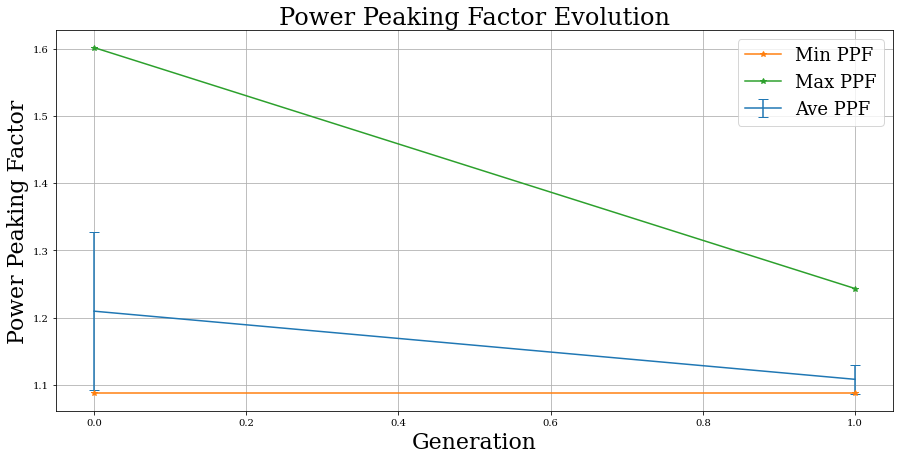

In [26]:
plot_1_obj(logbook, 0, "Power Peaking Factor", "PPF", True, "assem-obj-1-ppf-evol.png")

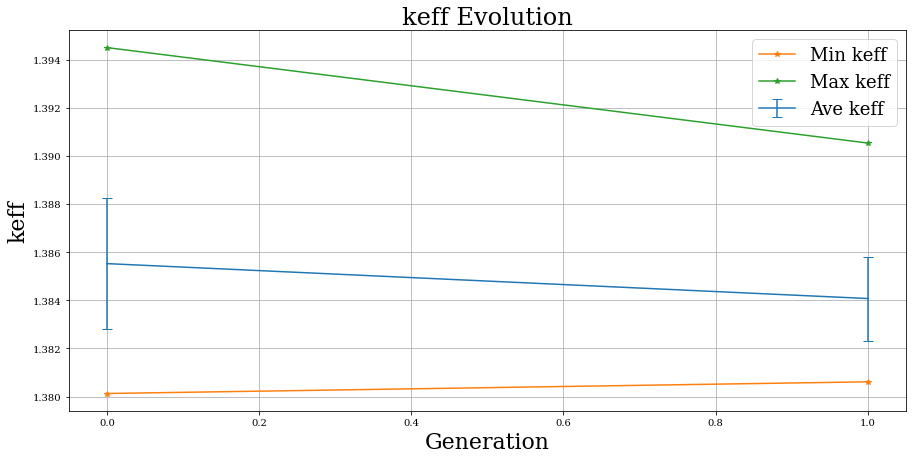

In [27]:
plot_1_obj(logbook, 1, "keff", "keff", False, "")

In [28]:
midpoints_discr_x = np.array([ 5.72081665,  7.75955614,  9.79829563, 11.83703513, 13.87577462, 
                     15.91451411, 17.9532536 , 19.9919931 , 22.03073259, 24.06947208])
midpoints_discr_y = np.array([19.775, 16.525, 13.275, 10.025,  6.775,  3.525])
def calc_pf_distr(ind, pf_present):
    if pf_present:
        total_pf, sine_a_x, sine_b_x, sine_c_x, sine_a_y, sine_b_y, sine_c_y = ind[0], ind[1], ind[2], ind[3], ind[4], ind[5], ind[6]
    else:
        sine_a_x, sine_b_x, sine_c_x, sine_a_y, sine_b_y, sine_c_y = ind[0], ind[1], ind[2], ind[3], ind[4], ind[5]
        total_pf = 0.04
    sine_val_discr_x = sine_a_x * sin(sine_b_x * midpoints_discr_x + sine_c_x) + 2
    sine_val_discr_y = sine_a_y * sin(sine_b_y * midpoints_discr_y + sine_c_y) + 2
    sine_val_distr_xy = sine_val_discr_y.reshape(6,1) * sine_val_discr_x.reshape(1,10) 
    vol_triso = 0.0003181623994807103
    vol_total = 419.3793150536547
    vol_slice = 6.989655250894246
    no_trisos = total_pf * vol_total / vol_triso
    triso_distr = sine_val_distr_xy / sum(sum(sine_val_distr_xy)) * no_trisos
    pf_distr = triso_distr * vol_triso / vol_slice
    return pf_distr

1 106 (1.087242485375202, 1.3849775948992449)
1.087
[0.812822458763012, 0.9268220614645086, 0.14909252938836615, 0.04641142874177695, 0.7398913008412474, 0.28043568059474216]
max 0.05733548223985999
1 72 (1.0879434226759968, 1.3818365852212535)
1.088
[0.5523194693371811, 1.019478550965582, 3.8769390124638483, 0.05665791037599721, 0.30958900447830273, 0.8961597941053948]
max 0.052307362120731574
1 61 (1.089587543679584, 1.3849993386523698)
1.09
[0.6080577358566337, 0.6011699629164375, 2.3652634272157016, 0.22939987393883685, 0.5162460684781158, 4.409219191525499]
max 0.056131367181359415
0 22 (1.0910242378343533, 1.3839604216625134)
1.091
[0.5215196116737126, 0.5109535596723018, 0.8645810536430081, 0.8140973614407521, 1.164361311240197, 2.727764524974369]
max 0.07030968036243468


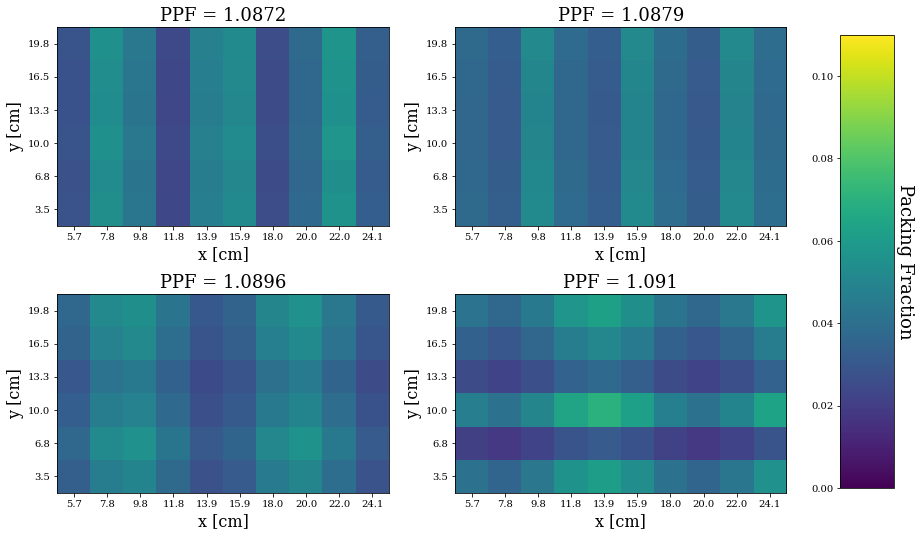

In [32]:
midpoints_discr_x_rounded = [ '%.1f' % elem for elem in midpoints_discr_x]
midpoints_discr_y_rounded = [ '%.1f' % elem for elem in midpoints_discr_y]
results = cp["all"]
pop = results["populations"][-1]
oup_results = results["outputs"][-1]
obj_0 = np.array([item[0] for item in oup_results])
sorted_index_0 = np.argsort(obj_0)
fig, axes = plt.subplots(figsize=(15,9), nrows=2, ncols=2)
count = 0
old_ppf = 0
for i in sorted_index_0[:25]:
    ind = pop[i]
    new_ppf = round(ind.output[0], 3)
    if new_ppf != old_ppf:
        print(ind.gen, ind.num, ind.output)
        print(new_ppf)
        print(ind)
        old_ppf = new_ppf
        ax = axes.flat[count]
        count += 1
        pf_distr = calc_pf_distr(ind, False)
        im = ax.imshow(pf_distr, vmin=0, vmax=0.11,cmap="viridis")
        print("max",np.amax(pf_distr))
        ax.set_title("PPF = "+str(round(oup_results[i][0],4)), fontsize=18)
        ax.set_xlabel("x [cm]", fontsize=16)
        ax.set_ylabel("y [cm]", fontsize=16)
        ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded)
        ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded)
        if count == 4:
            break
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cb.set_label("Packing Fraction", fontsize=18, rotation=270, labelpad=20)
#plt.savefig("assem-obj-1-ppf-final.png",bbox_inches='tight')

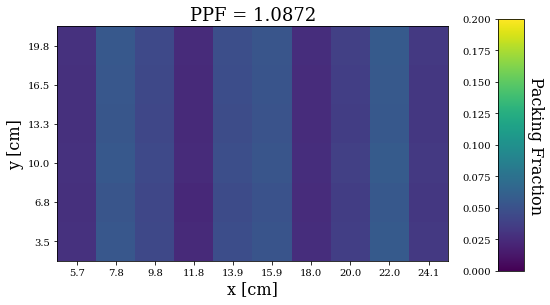

In [33]:
ind_most_minimized = pop[sorted_index_0[0]]
pf_distr = calc_pf_distr(ind_most_minimized, False)
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(pf_distr, vmin=0, vmax=0.2,cmap="viridis")
ax.set_title("PPF = "+str(round(ind_most_minimized.output[0],4)), fontsize=18)
ax.set_xlabel("x [cm]", fontsize=16)
ax.set_ylabel("y [cm]", fontsize=16)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cb.set_label("Packing Fraction", fontsize=16, rotation=270, labelpad=20)
#plt.savefig("a-1c-ppf-triso-comparison-most-minimized",bbox_inches='tight')

0.13713711927607644


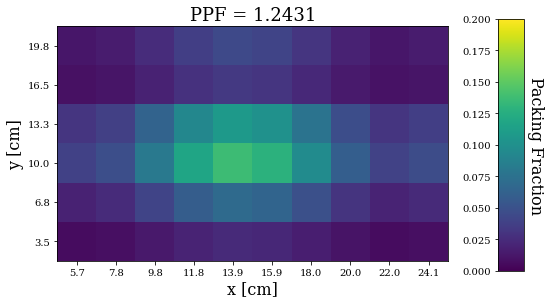

In [34]:
ind_least_minimized = pop[sorted_index_0[-1]]
pf_distr = calc_pf_distr(ind_least_minimized, False)
print(np.amax(pf_distr))
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(pf_distr, vmin=0, vmax=0.2,cmap="viridis")
ax.set_title("PPF = "+str(round(ind_least_minimized.output[0],4)), fontsize=18)
ax.set_xlabel("x [cm]", fontsize=16)
ax.set_ylabel("y [cm]", fontsize=16)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cb.set_label("Packing Fraction", fontsize=16, rotation=270, labelpad=20)
#plt.savefig("a-1c-ppf-triso-comparison-least-minimized",bbox_inches='tight')